In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

pd.set_option("display.max_columns", None)

print('success')

success


### Processing images

We load the train,test,val images here

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
17696,fffb900a92289a33.jpg,[healthy]
17697,fffc488fa4c0e80c.jpg,[scab]
17698,fffc94e092a59086.jpg,[rust]
17699,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2029
frog_eye_leaf_spot    4125
healthy               4387
powdery_mildew        1226
rust                  1965
scab                  5442
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

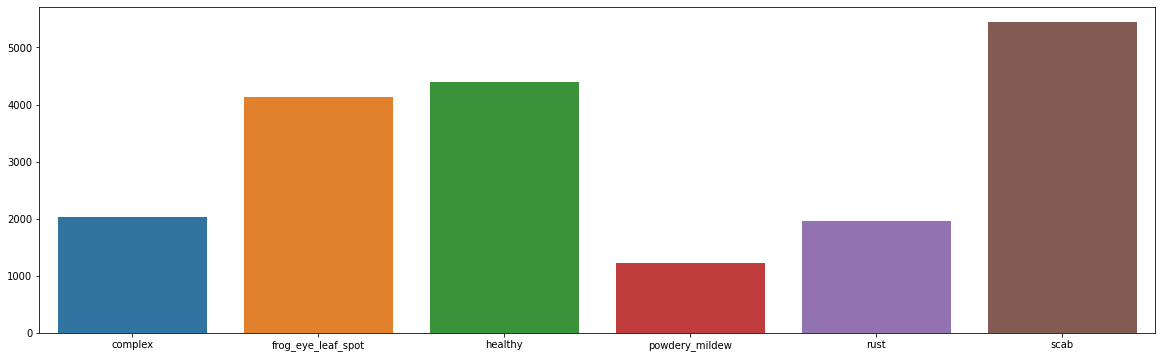

In [4]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

### Viewing some images

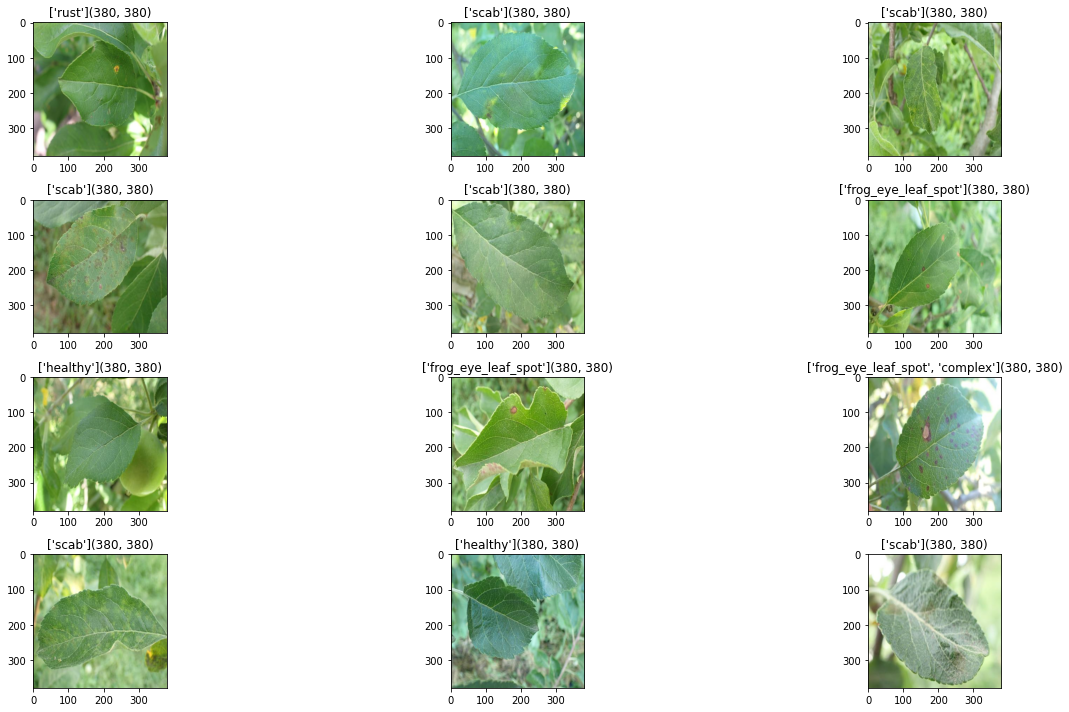

In [5]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, len(list(train['image'])))
    sample = os.path.join('./train_images380/', train['image'][rand])
    
    img = Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=5,
                            zoom_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    train,
    directory='./train_images380',
    subset='training',
    x_col='image',
    y_col='labels',
    target_size=(380,380),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

#'../input/plant-pathology-2021-fgvc8/train_images'
valid_generator = datagen.flow_from_dataframe(
    train,
    directory='./train_images380',
    subset='validation',
    x_col='image',
    y_col='labels',
    target_size=(380,380),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

Found 15931 validated image filenames belonging to 6 classes.
Found 1770 validated image filenames belonging to 6 classes.


In [34]:
# img_augmentation = tf.keras.Sequential(
#     [
#         keras.layers.RandomRotation(factor=0.15),
#         keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#         keras.layers.RandomFlip(),
#         keras.layers.RandomContrast(factor=0.1),
#     ],
#     name="img_augmentation",
# )

In [7]:
model=keras.Sequential()
model.add(keras.layers.Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(380,380,3)))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(6, 
    kernel_initializer=keras.initializers.RandomUniform(seed=1200),
    bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid'))


print(model.output)
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='dense_top/Sigmoid:0', description="created by layer 'dense_top'")
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 380, 380, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 190, 190, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 190, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 95, 95, 64)       0         
 2D)                                                             
                         

2022-04-16 12:42:13.096316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-16 12:42:13.096408: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(
#     physical_devices[0], enable='True'
# )

# import PIL.Image

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [9]:
# from tensorflow.keras.callbacks import EarlyStopping
import PIL
f1 = tfa.metrics.F1Score(num_classes=6,average='macro')


model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',f1])
# callbacks = keras.callbacks.EarlyStopping(monitor='f1_score', patience=4, mode='max', restore_best_weights=True)
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=15,
                    steps_per_epoch=train_generator.samples//256, # = 58
                    validation_steps=valid_generator.samples//128,)
                    # callbacks=callbacks)


Epoch 1/15


2022-04-16 12:42:44.396976: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-16 12:42:44.795900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.2451 - f1_score: 0.1311

2022-04-16 12:43:43.941257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 66s 1s/step - loss: 0.4620 - accuracy: 0.2451 - f1_score: 0.1311 - val_loss: 0.4274 - val_accuracy: 0.3221 - val_f1_score: 0.0875
Epoch 2/15
62/62 [==============================] - 63s 1s/step - loss: 0.4284 - accuracy: 0.3075 - f1_score: 0.2106 - val_loss: 0.3999 - val_accuracy: 0.4087 - val_f1_score: 0.2742
Epoch 3/15
62/62 [==============================] - 64s 1s/step - loss: 0.4159 - accuracy: 0.3332 - f1_score: 0.2505 - val_loss: 0.4015 - val_accuracy: 0.3365 - val_f1_score: 0.1727
Epoch 4/15
62/62 [==============================] - 65s 1s/step - loss: 0.4072 - accuracy: 0.3750 - f1_score: 0.3565 - val_loss: 0.3933 - val_accuracy: 0.4303 - val_f1_score: 0.4144
Epoch 5/15
62/62 [==============================] - 66s 1s/step - loss: 0.3993 - accuracy: 0.4002 - f1_score: 0.3700 - val_loss: 0.3761 - val_accuracy: 0.4111 - val_f1_score: 0.3706
Epoch 6/15
62/62 [==============================] - 78s 1s/step - loss: 0.3978 - accuracy: 0.3866 - f

In [10]:
model.save("vanilla_cnn_model.h5")

In [57]:
# test_data = datagen.flow_from_dataframe(
#     test,
#     directory = './test_size256_images',
#     x_col="image",
#     y_col= None,
#     color_mode="rgb",
#     target_size = (256,256),
#     classes=None,
#     class_mode=None,
#     batch_size=32,
#     shuffle=False,
#     seed=40,
# )

test_data = datagen.flow_from_dataframe(
    test,
    directory = './test_images380',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (380,380),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

# train_generator = datagen.flow_from_dataframe(
#     train,
#     directory='./train_images',
#     subset='training',
#     x_col='image',
#     y_col='labels',
#     target_size=(224,224),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=64,
#     shuffle=True,
#     seed=444
#     )


preds = model.predict(test_data)
print(preds)
preds = preds.tolist()

# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
threshold = {0: 0.26, # Complex
             5: 0.61, # scab
             1: 0.7, # frog eye leaf spot
             4: 0.5, # rust
             3: 0.5, # powdery mildew
             2: 0.3} #healthy

             
# Can set different threshold here
indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
print(indices[:10])

Found 931 validated image filenames.
[[2.5896687e-02 1.8667689e-01 1.5601902e-01 4.7698516e-02 9.7911768e-02
  1.3657989e-01]
 [4.1871130e-02 4.4397673e-01 6.6182081e-05 1.8561420e-03 1.6868085e-01
  1.1479635e-02]
 [4.3134604e-02 3.8857901e-01 1.5447324e-02 5.0872958e-01 1.3493705e-02
  1.8585855e-01]
 ...
 [2.9877141e-01 3.5787871e-01 6.3388594e-05 6.8175903e-04 1.3279134e-01
  1.2891011e-01]
 [3.3605792e-02 6.7016773e-02 3.6406493e-01 8.2549892e-02 3.7259969e-01
  2.3143899e-01]
 [9.6847825e-02 2.4004322e-01 1.5639240e-01 4.8834588e-02 1.9034402e-02
  2.9898509e-01]]
[[1], [1], [3], [0], [5], [0, 4], [2], [0, 1, 4], [2], [0]]


In [38]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels[:10])

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'powdery_mildew', 'complex', 'scab', 'complex rust', 'healthy', 'complex frog_eye_leaf_spot rust', 'healthy', 'complex']


In [39]:
actuallabels = list(test['labels'])
print(actuallabels[:10])

['healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'frog_eye_leaf_spot', 'scab', 'rust', 'healthy', 'frog_eye_leaf_spot', 'scab', 'scab']


In [14]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(actuallabels,testlabels)
print(f"Test accuracy score: {accuracy}")

Test accuracy score: 0.5166487647690655


In [56]:
import numpy as np
import sklearn
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_true = ["cat", "ant", "cat", "cat", "cat ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "bird ant", "cat"]

y_true = mlb.fit_transform([list(i.split(" ")) for i in y_true])
y_pred = mlb.fit_transform([list(i.split(" ")) for i in y_pred])

print("y_true:")
print(y_true)
print("y_pred:")
print(y_pred)

print("classes:")
print(mlb.classes_)

x= multilabel_confusion_matrix(y_true, y_pred)

print("Matrix:")
print(x)

y_true:
[[0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 1]
 [0 1 0]]
y_pred:
[[1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 1 0]
 [0 0 1]]
classes:
['ant' 'bird' 'cat']
Matrix:
[[[3 1]
  [0 2]]

 [[4 1]
  [1 0]]

 [[1 1]
  [2 2]]]


In [55]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

actuallabelsbin = mlb.fit_transform([list(i.split(" ")) for i in actuallabels])
testlabelsbin = mlb.fit_transform([list(i.split(" ")) for i in testlabels])

# print(actuallabels)
# print(testlabels)
print(mlb.classes_)

matrix = multilabel_confusion_matrix(actuallabelsbin, testlabelsbin)
print(matrix)

['complex' 'frog_eye_leaf_spot' 'healthy' 'powdery_mildew' 'rust' 'scab']
[[[706 103]
  [ 41  81]]

 [[670  34]
  [116 111]]

 [[540 154]
  [ 32 205]]

 [[835  51]
  [ 17  28]]

 [[797  22]
  [ 33  79]]

 [[614  47]
  [207  63]]]


In [29]:
actual_test = pd.read_csv('sample_submission.csv')

In [48]:
for img_name in tqdm(actual_test['image']):
    path = './actual_test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((380,380))
        img.save(f'./actual_test_images/{img_name}')

100%|██████████| 3/3 [00:00<00:00,  6.78it/s]


In [31]:
actual_test_data = datagen.flow_from_dataframe(
    actual_test,
    directory = './actual_test_images',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (380,380),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

actual_preds = model.predict(actual_test_data)
print(actual_preds)
actual_preds = actual_preds.tolist()

# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
threshold = {0: 0.26, # Complex
             5: 0.61, # scab
             1: 0.7, # frog eye leaf spot
             4: 0.5, # rust
             3: 0.5, # powdery mildew
             2: 0.3} #healthy

             
# Can set different threshold here
indices = []
for pred in actual_preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
print(indices)

Found 3 validated image filenames.
[[0.00109181 0.00084057 0.20466545 0.00479949 0.78259766 0.28966954]
 [0.34206405 0.45278743 0.01013521 0.11293902 0.09910273 0.18558347]
 [0.0169368  0.19765083 0.16010019 0.0156516  0.06949074 0.2560975 ]]
[[4], [0], [5]]


In [32]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

actualtestlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    actualtestlabels.append(' '.join(temp))

print(actualtestlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['rust', 'complex', 'scab']


In [33]:
sub = pd.read_csv('./sample_submission.csv')
sub['labels'] = actualtestlabels
sub.to_csv('submission.csv', index=False)
sub

,image,labels
0,85f8cb619c66b863.jpg,rust
1,ad8770db05586b59.jpg,complex
2,c7b03e718489f3ca.jpg,scab
